In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path
sys.path.append('..')

import pickle
import json
import numpy as np

# Script params

In [3]:
max_len = 200
embedding_dim = 100

# Loading glove embedding

In [4]:
glove_embedding = {}
with open('/Users/lukaszmaczewski/Documents/Learning/DeepNeuralNetworks/keras/data/glove.6B.100d.txt', 'r') as f:
    while True:
        line = f.readline()
        if line == '':
            break
        line = line.split()
        glove_embedding[line[0]] = np.asarray(line[1:], dtype='float32')

# Load train and test data

In [5]:
from keras.utils import pad_sequences

2023-08-18 16:01:18.612293: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
with open('/Users/lukaszmaczewski/Documents/Learning/DeepNeuralNetworks/keras/data/aclImdb/corpus_train_df.pkl', 'rb') as f:
    train_df = pickle.load(f)
with open('/Users/lukaszmaczewski/Documents/Learning/DeepNeuralNetworks/keras/data/aclImdb/corpus_test_df.pkl', 'rb') as f:
    test_df = pickle.load(f)
with open('/Users/lukaszmaczewski/Documents/Learning/DeepNeuralNetworks/keras/data/aclImdb/token2index.json', 'r') as f:
    token2index = json.load(f)
with open('/Users/lukaszmaczewski/Documents/Learning/DeepNeuralNetworks/keras/data/aclImdb/index2token.json', 'r') as f:
    index2token = json.load(f)

In [7]:
max_index = max(list(token2index.values())) + 1

In [8]:
x_train = pad_sequences(train_df.token_indexes.values, maxlen = max_len)
y_train = train_df.labels.values
x_test = pad_sequences(test_df.token_indexes.values, maxlen = max_len)
y_test = test_df.labels.values

In [9]:
x_train.shape, y_train.shape

((25000, 200), (25000,))

In [10]:
x_test.shape, y_test.shape

((25000, 200), (25000,))

# Create glove based embedding matrix for keras

In [11]:
embedding_matrix = np.zeros((max_index,embedding_dim))

In [12]:
for token, index in token2index.items():
    embedding_vector = glove_embedding.get(token)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# Training simple dnn with embedding layer

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Conv1D, MaxPooling1D, LSTM, BatchNormalization
from keras.metrics import AUC, BinaryAccuracy
from keras.optimizers import RMSprop

In [14]:
model = Sequential()
model.add(Embedding(max_index, embedding_dim))
model.add(Conv1D(50, 3, activation = 'relu'))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1734200   
                                                                 
 conv1d (Conv1D)             (None, None, 50)          15050     
                                                                 
 lstm (LSTM)                 (None, 50)                20200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 1

2023-08-18 16:01:26.859329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-18 16:01:26.860645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-18 16:01:26.862855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [15]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [16]:
optimizer = RMSprop(learning_rate=0.002, momentum = 0.3)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[BinaryAccuracy(), AUC()])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1734200   
                                                                 
 conv1d (Conv1D)             (None, None, 50)          15050     
                                                                 
 lstm (LSTM)                 (None, 50)                20200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 1

In [18]:
fit_history = model.fit(x_train,
                        y_train,
                        epochs=15,
                        batch_size=64,
                        validation_data=(x_test, y_test)
                       )

Epoch 1/15


2023-08-18 16:01:27.633369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-18 16:01:27.635160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-18 16:01:27.636414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

391/391 [==============================] - ETA: 0s - loss: 0.5220 - binary_accuracy: 0.7453 - auc: 0.8196

2023-08-18 16:02:02.356474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-18 16:02:02.357584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-18 16:02:02.359516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

391/391 [==============================] - 46s 114ms/step - loss: 0.5220 - binary_accuracy: 0.7453 - auc: 0.8196 - val_loss: 0.3865 - val_binary_accuracy: 0.8248 - val_auc: 0.9110
Epoch 2/15
391/391 [==============================] - 46s 117ms/step - loss: 0.3929 - binary_accuracy: 0.8317 - auc: 0.9050 - val_loss: 0.3463 - val_binary_accuracy: 0.8501 - val_auc: 0.9276
Epoch 3/15
391/391 [==============================] - 46s 119ms/step - loss: 0.3474 - binary_accuracy: 0.8562 - auc: 0.9261 - val_loss: 0.3386 - val_binary_accuracy: 0.8522 - val_auc: 0.9315
Epoch 4/15
391/391 [==============================] - 50s 128ms/step - loss: 0.3216 - binary_accuracy: 0.8662 - auc: 0.9370 - val_loss: 0.3268 - val_binary_accuracy: 0.8572 - val_auc: 0.9346
Epoch 5/15
391/391 [==============================] - 47s 119ms/step - loss: 0.2966 - binary_accuracy: 0.8792 - auc: 0.9466 - val_loss: 0.3518 - val_binary_accuracy: 0.8484 - val_auc: 0.9333
Epoch 6/15
391/391 [==============================] - 47

In [19]:
from kst.plots.BasePlots import BasePlots, ScatterPlot
import pandas as pd
from plotnine import aes, geom_point, geom_line, ylim, labs, theme

In [20]:
df = pd.DataFrame.from_dict(fit_history.history)
df['epoch'] = df.index.to_list()
df

,loss,binary_accuracy,auc,val_loss,val_binary_accuracy,val_auc,epoch
0,0.522030,0.74528,0.819586,0.386518,0.82480,0.910950,0
1,0.392878,0.83168,0.905044,0.346334,0.85012,0.927556,1
2,0.347391,0.85620,0.926088,0.338613,0.85220,0.931454,2
3,0.321641,0.86624,0.936992,0.326801,0.85716,0.934645,3
4,0.296597,0.87920,0.946587,0.351830,0.84836,0.933305,4
5,0.272325,0.88912,0.954866,0.336227,0.86076,0.935786,5
6,0.251810,0.89928,0.961623,0.348857,0.85244,0.934272,6
7,0.225994,0.91072,0.968839,0.374366,0.85124,0.931250,7
8,0.206155,0.91900,0.973987,0.398019,0.85520,0.930333,8
9,0.184129,0.92772,0.979060,0.420992,0.85132,0.925140,9


In [21]:
sc = ScatterPlot(data_set=df,
                 aes = {'x':'epoch', 'y':'loss', 'color':"'training'"},
                 main_title='Binary crossentropy',
                 x_label='Epoch',
                 y_label='Loss',
                 legend_title='',
                 line = geom_line()
              )

sc.add_gg_object(geom_point(df, aes(x = 'epoch', y = 'val_loss', color = "'validation'")))
sc.add_gg_object(geom_line(df, aes(x = 'epoch', y = 'val_loss', color = "'validation'")))

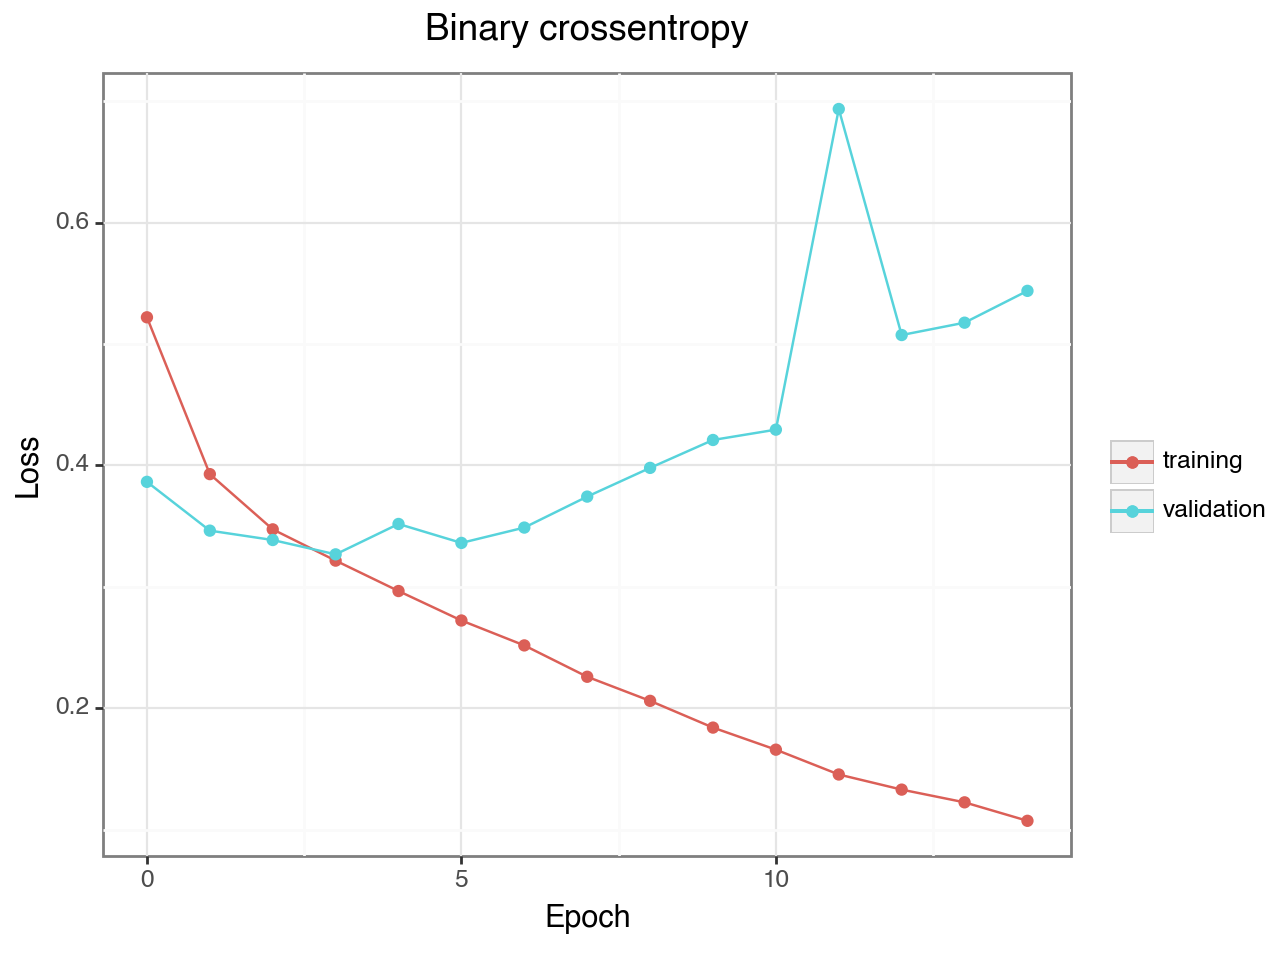

<Figure Size: (640 x 480)>

In [22]:
sc.plot

In [23]:
sc = ScatterPlot(data_set=df,
                 aes = {'x':'epoch', 'y':'auc', 'color':"'training'"},
                 main_title='Area under curve',
                 x_label='Epoch',
                 y_label='Binary accuracy',
                 legend_title='',
                 line = geom_line()
              )

sc.add_gg_object(geom_point(df, aes(x = 'epoch', y = 'val_auc', color = "'validation'")))
sc.add_gg_object(geom_line(df, aes(x = 'epoch', y = 'val_auc', color = "'validation'")))

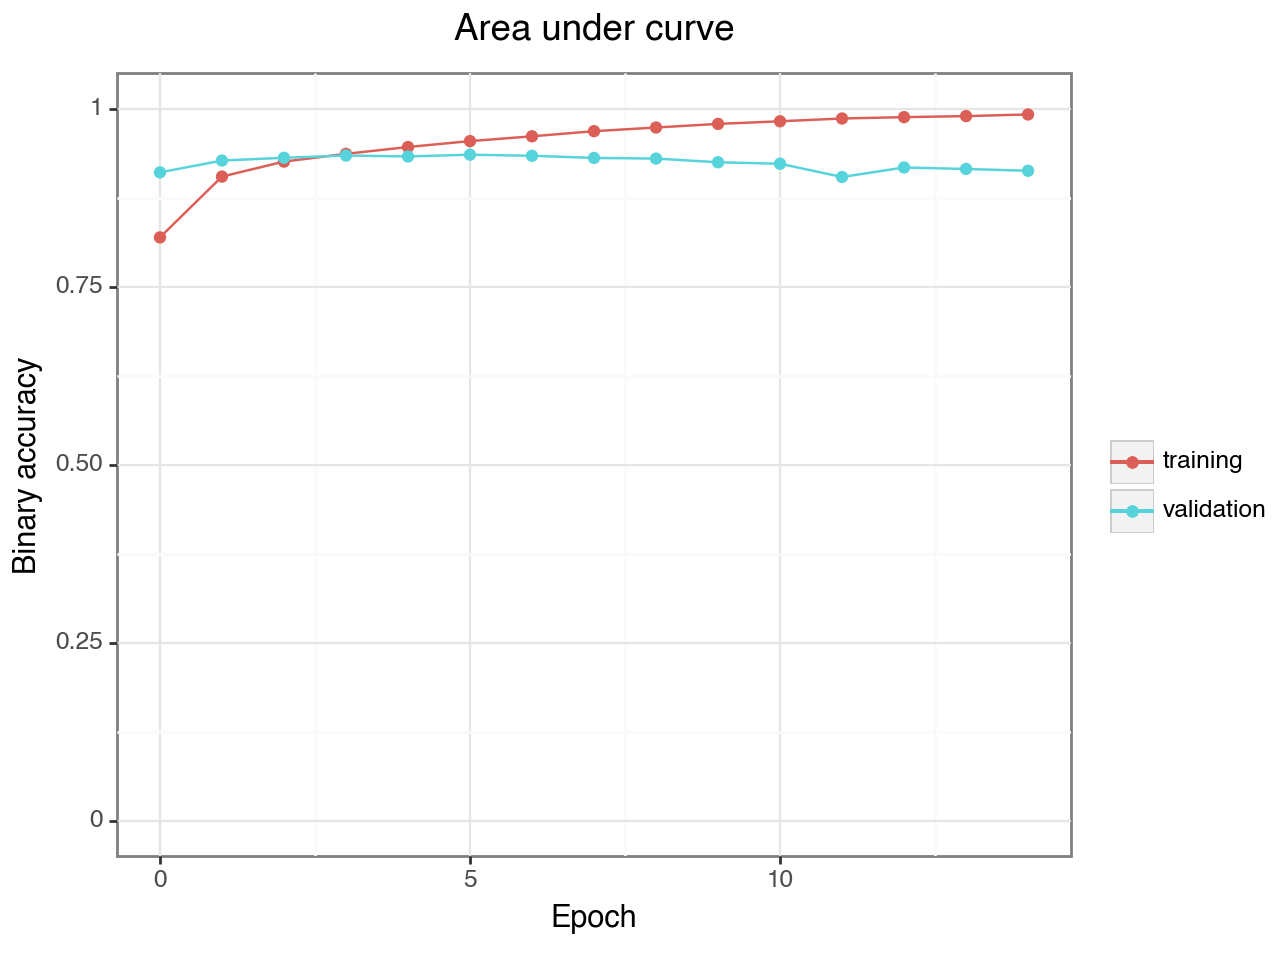

<Figure Size: (640 x 480)>

In [24]:
sc.plot + ylim(0,1)

In [25]:
sc = ScatterPlot(data_set=df,
                 aes = {'x':'epoch', 'y':'binary_accuracy', 'color':"'training'"},
                 main_title='Binarry accuracy',
                 x_label='Epoch',
                 y_label='Binary accuracy',
                 legend_title='',
                 line = geom_line()
              )

sc.add_gg_object(geom_point(df, aes(x = 'epoch', y = 'val_binary_accuracy', color = "'validation'")))
sc.add_gg_object(geom_line(df, aes(x = 'epoch', y = 'val_binary_accuracy', color = "'validation'")))

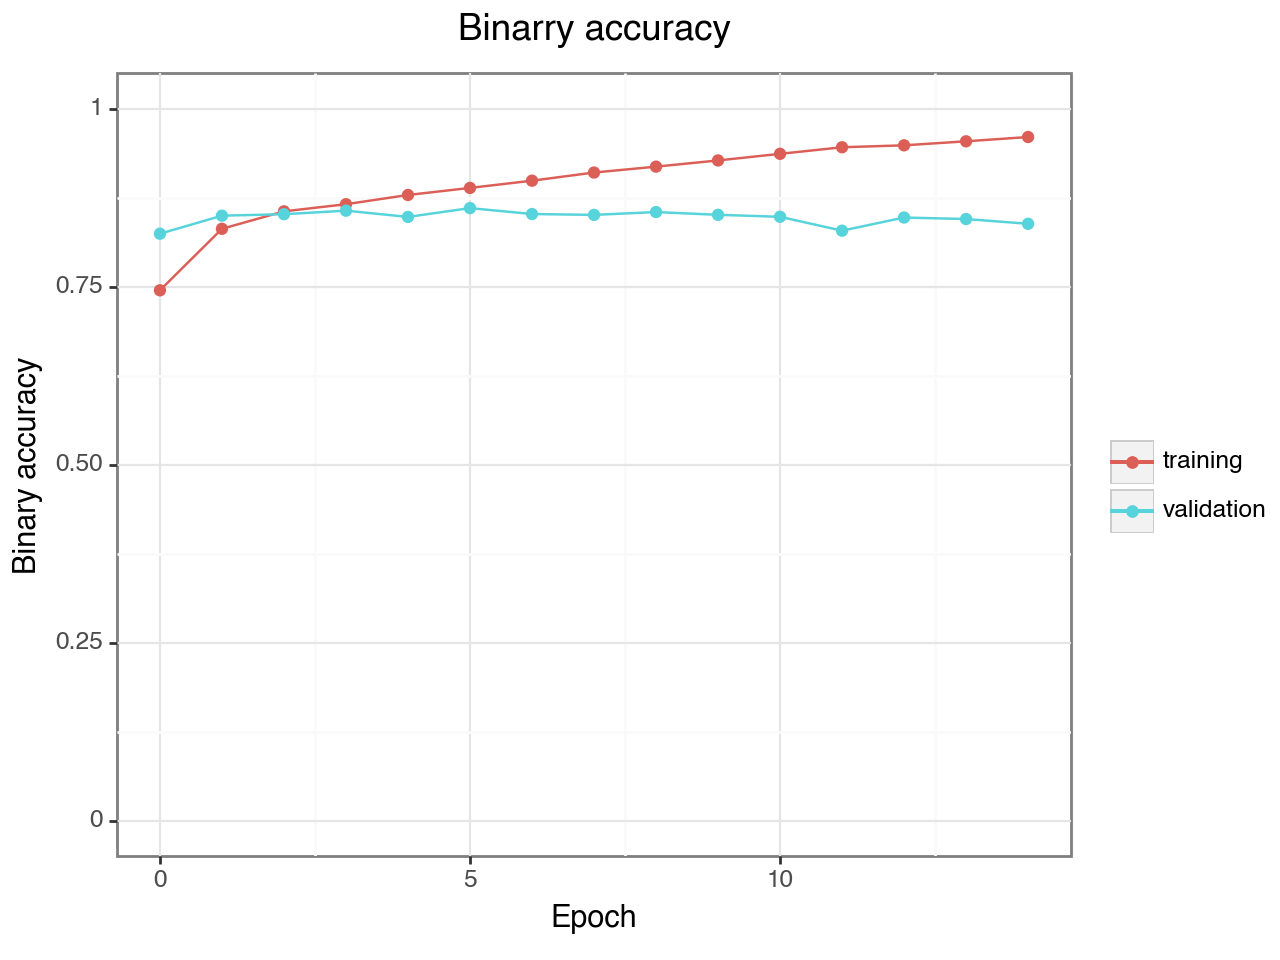

<Figure Size: (640 x 480)>

In [26]:
sc.plot + ylim(0,1)